#DATASCI W261: Machine Learning at Scale

Nick Hamlin
nickhamlin@gmail.com  
Time of Submission: 12:15 AM EST, Tuesday, January 26, 2016  
W261-3, Spring 2016  
Week 2 Homework

###Submission Notes:
- For each problem, I've included a summary of the question as posed in the instructions.  In many cases, I have not included the full text to keep the final submission as uncluttered as possible.  For reference, I've included a link to the original instructions in the "Useful Reference" below.
- Problem statements are listed in *italics*, while my responses are shown in plain text. 
- I have written driver functions for each problem where a solution is provided in pure Python.  For simplicity, I have omitted them for the sections that use Bash commands either directly or to create files.

###Useful References:
- **[Original Assignment Instructions](https://www.dropbox.com/sh/bkpb50k058h33ln/AACotBIUNrl5CYOLC59wj0oCa/HW2-Questions.txt?dl=0)**
- [Wikipedia explanation of Naive Bayes document classification](https://en.wikipedia.org/wiki/Naive_Bayes_classifier#Document_classification)
- [Original paper describing the background of the Enron email corpus](http://www.aueb.gr/users/ion/docs/ceas2006_paper.pdf)
- [Documentation for Scikit-Learn implementation of Naive Bayes](http://scikit-learn.org/stable/modules/naive_bayes.html)
- [Stanford NLP Group's explaination of Naive Bayes algorithm](http://nlp.stanford.edu/IR-book/html/htmledition/properties-of-naive-bayes-1.html)
- [NBViewer example of Hadoop Word Count](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/dkyjsoi23zawiah/Hadoop%20Streaming%20WordCount.ipynb)  

###Handy Hadoop Links:
- [Jobtracker](http://localhost:8088/cluster)  
- [Namenode](http://localhost:50070/dfshealth.html#tab-overview)

##HW2.0.  
*What is a race condition in the context of parallel computation? Give an example.* 

A race condition occurs when the output of a calculation relies on the correct timing of preceeding parallel processes, but these predecessor events do not happen in the right order. If two threads are completing a task in parallel, we may not know the order in which the tasks will complete.  This can cause the end result of the computation to be different.  

The async slides contain a simple example. If task A and task B both take the variable X, increment it by 1, and write the result back to variable X, multiple outcomes are possible. A may run completely first before B reads X, resulting in a final result of X+2.  Alternatively, B may read before A finishes writing to X, causing B's result to overwrite A's and incrementing X only by 1.  The fact that the program doesn't adequately address this synchronization problem is what causes the race condition.



*What is MapReduce?* 

MapReduce is a generic programming framework for processing big data that capitalizes on a parallel processing structure.  It does this by breaking a task into two main steps.  The first stage (the "Map" step) takes applies user-specified logic to all input data.  The second stage (the "Reduce" step) collects the output of the map step and aggregates it into a final response.  Other intermediate steps, including a "combiner" between the map and reduce steps can make the process more efficient by reducing the amount of data that needs to pass from the mapper to the reducer across a network.  In practice, several MapReduce jobs can be chained together to enable the implementation of more complex algorithms (like Naive Bayes, as shown in subsequent problems on this assignment).

A schematic of the MapReduce process makes this process clear (Image courtesy of http://blog.matthewrathbone.com/)

![](http://blog.matthewrathbone.com/img/map-reduce.png)





*How does it differ from Hadoop?* 

Hadoop is a particular open-source implementation of the MapReduce framework written in Java that takes care of many of the tedious coordination, synchronization, and communication tasks required to effectively execute a MapReduce job on a cluster.  With Hadoop, at a minimum, the user needs to specify only the logic for the map and reduce tasks and the input and output location for the data (though other parameters may be defined by the user, it isn't required to run a job successfully).  In turn, Hadoop decides how to divide the task across the different nodes in the cluster, automatically reallocates work in the event of a node failure, and, unless overridden, sorts the data between the map and reduce steps to minimize network throughput.  

*Which programming paradigm is Hadoop based on? Explain and give a simple example in code and show the code running.*  

MapReduce (and, by extension, Hadoop) is based on the functional programming paradigm.  Key to functional programming is the concept of "higher-order functions": functions that accept functions as inputs.  In the case of MapReduce in Hadoop, "Map" is a higher-order function that accepts some input function (defined by the user) and executes it on a set of data.  "Reduce" then aggregates the results generated by map, similar to the "fold" function in functional programming.  The end result lends itself well to parallelization because it doesn't do the work to compute a result until an answer is required.

The code below shows a simple functional programming example in Python, using the built-in Map function to apply a function across a data set.


In [26]:
#HW 2.0 Functional Programming Example

def multiply_by_three(a):
    """multiplies the input by 3"""
    return a*3

def run_2_0():
    print "Input data:"
    input=[1,2,3,4,5,6] #dataset across which we want to apply our function
    print input
    print ""
    print "Output:"
    
    #The map function accepts the multiply_by_three function and applies it over our input data
    output=map(multiply_by_three,input) 
    print output

run_2_0()

Input data:
[1, 2, 3, 4, 5, 6]

Output:
[3, 6, 9, 12, 15, 18]


##HW2.1. Sort in Hadoop Mapreduce

*Given as input: Records of the form {integer, 'NA'}, where integer is any integer, and 'NA' is just the empty string. Output: sorted key value pairs of the form {integer, “NA”} in decreasing order; what happens if you have multiple reducers? Do you need additional steps? Explain.*

If you have multiple reducers, you'll need a way of ensuring that every integer gets compared to every other integer, or else you can't know if the list is sorted.  One way to do this would be to perform an intermediate sort with multiple reducers during a first-pass MapReduce job and then implement a second job with an identity mapper and only a single reducer.

*Write code to generate N random records of the form {integer, “NA”}. Let N = 10,000.
Write the python Hadoop streaming map-reduce job to perform this sort. Display the top 10 biggest numbers. Display the 10 smallest numbers*

####HW 2.1 - Generate random integers
We can use numpy's randint function to accomplish this task easily, and write the result to file for later use

In [31]:
#HW 2.1 - Generate Random Integers
import numpy as np

with open("numbers_10k.txt",'wb') as f:
    #I've chosen 1,000,000 as the upper bound, and we want to generate 10,000 results
    for i in np.random.randint(10000000, size=10000):
        f.write(str(i)+',NA'+'\n')

In [28]:
#Display first 10 rows in the file to make sure everything worked
!cat numbers.txt | head -10

8442984,NA
9062303,NA
8691814,NA
8985205,NA
5506205,NA
7740370,NA
8135881,NA
5581266,NA
8985155,NA
4864390,NA


####HW 2.1 - Mapper and Reducer
Because we just want to sort the integers, we can take advantage of Hadoop's built-in sorting behavior, which automatically sorts the outputs of the mapper before sending them to the reducer.  This means that our mapper and reducer functions can simply pass the data through and offload the sorting task to Hadoop

In [177]:
%%writefile mapper.py
#!/usr/bin/python

#HW 2.1 - Mapper Function Code
import sys
for line in sys.stdin:
    print "%s" % (line.strip())

Overwriting mapper.py


In [178]:
%%writefile reducer.py
#!/usr/bin/python

#HW 2.1 - Reducer Function Code
import sys
for line in sys.stdin:
    print "%s" % (line.strip())

Overwriting reducer.py


####HW 2.1 - Running the MapReduce Job

In [179]:
#Load the input data into HDFS and make sure the output directory is clear
!bin/hdfs dfs -put numbers_10k.txt
!bin/hdfs dfs -rm -r numbers-output

Deleted numbers-output


In [180]:
%%bash
#Run the job, making sure that we tell hadoop to use a descending numerical sort
bin/hadoop jar share/hadoop/tools/lib/hadoop-streaming-2.6.3.jar \
-D mapred.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
-D  mapred.text.key.comparator.options=-nr \
-file ./mapper.py    -mapper ./mapper.py \
-file ./reducer.py   -reducer ./reducer.py \
-input /user/nicholashamlin/numbers_10k.txt -output /user/nicholashamlin/numbers-output

packageJobJar: [./mapper.py, ./reducer.py, /var/folders/rz/drh189k95919thyy3gs3tq400000gn/T/hadoop-unjar3367581719496032789/] [] /var/folders/rz/drh189k95919thyy3gs3tq400000gn/T/streamjob7333534975216928512.jar tmpDir=null


In [181]:
# Examine the output of the job in HDFS and print the results
! echo "HW 2.1 RESULTS:"
! echo "10 Largest Numbers:"
!bin/hdfs dfs -cat numbers-output/* | head -10
! echo ""
! echo "10 Smallest Numbers:"
!bin/hdfs dfs -cat numbers-output/* | tail -10

HW 2.1 RESULTS:
10 Largest Numbers:
9999452,NA	
9998692,NA	
9997041,NA	
9995974,NA	
9995778,NA	
9995720,NA	
9995081,NA	
9991001,NA	
9990592,NA	
9989264,NA	
cat: Unable to write to output stream.

10 Smallest Numbers:
13980,NA	
11426,NA	
10841,NA	
10585,NA	
10449,NA	
10150,NA	
8299,NA	
7200,NA	
5257,NA	
1831,NA	


##HW2.2 - Wordcount

*Using the Enron data from HW1 and Hadoop MapReduce streaming, write the mapper/reducer job that  will determine the word count (number of occurrences) of each white-space delimitted token (assume spaces, fullstops, comma as delimiters). Examine the word “assistance” and report its word count results.*

####HW 2.2 - Mapper and Reducer
We can reuse most of the logic from last week's homework here, though we do have to modify it to read its input data directly from stdin rather than from a file on disk.  Fortunately, this change makes the code simpler

In [182]:
%%writefile mapper.py
#!/usr/bin/python

#HW 2.2 - Mapper Function Code
import sys
count = 0 #Running total of occurrances for the chosen word
findword = "assistance" 
for line in sys.stdin:
    subject_and_body=" ".join(line.split('\t')[-2:])#parse the subject and body fields from the line, and combine into one string
    count+=subject_and_body.count(findword) #Python's str.count() method makes counting the instances of the word easy
print findword+'\t'+str(count)

Overwriting mapper.py


In [183]:
%%writefile reducer.py
#!/usr/bin/python

#HW 2.2 - Reducer Function Code
import sys
sum = 0 #Running total of occurrances for the chosen word
for i in sys.stdin:
    line=i.split('\t') #Parse line into a list of fields
    sum+=int(line[1]) #Extract chunk count from the second field of each incoming line
print line[0]+'\t'+str(sum)

Overwriting reducer.py


####HW 2.2 - Running the MapReduce Job

In [184]:
#Use the command line to test that our modified mapper/reducer files still work right
!cat enronemail_1h.txt | ./mapper.py | ./reducer.py

assistance	10


In [185]:
#Load the input data into HDFS and make sure the output directory is clear
#!bin/hdfs dfs -put enronemail_1h.txt
!bin/hdfs dfs -rm -r hw_2_2_output

Deleted hw_2_2_output


In [186]:
%%bash
#Run the job in Hadoop
bin/hadoop jar share/hadoop/tools/lib/hadoop-streaming-2.6.3.jar \
-file ./mapper.py    -mapper ./mapper.py \
-file ./reducer.py   -reducer ./reducer.py \
-input /user/nicholashamlin/enronemail_1h.txt -output /user/nicholashamlin/hw_2_2_output

packageJobJar: [./mapper.py, ./reducer.py, /var/folders/rz/drh189k95919thyy3gs3tq400000gn/T/hadoop-unjar6740891941793277674/] [] /var/folders/rz/drh189k95919thyy3gs3tq400000gn/T/streamjob555687766092452517.jar tmpDir=null


In [187]:
#Examine results in HDFS
! echo "HW 2.2 RESULTS:"
!bin/hdfs dfs -cat hw_2_2_output/*

HW 2.2 RESULTS:
assistance	10


##HW2.2.1  
*Using Hadoop MapReduce and your wordcount job (from HW2.2) determine the top-10 occurring tokens (most frequent tokens)*

####HW 2.2.1 - First Mapper and Reducer Pair
To accomplish this task, we're going to use two MapReduce jobs chained together, where the output of the first job becomes the input to the second.  For this first job, I've used a slightly different version of the word count code based on the solutions to last week's homework. The mapper parses the incoming data into separate words and emits a record for every occurrence of every word. The reducer aggregates these results efficiently by leveraging Hadoop's sorting functionality.  This allows the reducer to assume that the words are in order, and therefore it doesn't need to hold the running list of words in memory.  It can simply process one word at a time and emit the result when it's complete.

In [188]:
%%writefile mapper.py
#!/usr/bin/python

#HW 2.2.1 - Mapper Function Code
import sys
# input comes from STDIN (standard input)
for line in sys.stdin:
    # remove leading and trailing whitespace
    line = line.strip()
    # split the line into words
    subject_and_body=" ".join(line.split('\t')[-2:])
    words=subject_and_body.split()
    # increase counters
    for word in words:
        # write the results to STDOUT (standard output);
        # what we output here will be the input for the
        # Reduce step, i.e. the input for reducer.py
        #
        # tab-delimited; the trivial word count is 1
        print '%s\t%s' % (word, 1)

Overwriting mapper.py


In [189]:
%%writefile reducer.py
#!/usr/bin/python

#HW 2.2.1 - Reducer Function Code
from operator import itemgetter
import sys

current_word = None #What word are we processing right now?
current_count = 0 #How many times have we seen that word?
word = None

# input comes from STDIN
for line in sys.stdin:
    # remove leading and trailing whitespace
    line = line.strip()

    # parse the input we got from mapper.py
    word, count = line.split('\t', 1)

    # convert count (currently a string) to int
    try:
        count = int(count)
    except ValueError:
        # count was not a number, so silently
        # ignore/discard this line
        continue

    # this IF-switch only works because Hadoop sorts map output
    # by key (here: word) before it is passed to the reducer
    if current_word == word:
        current_count += count #Increment count if we're still seeing data about the current word
    else:
        if current_word:
            # write result to STDOUT
            print '%s\t%s' % (current_word, current_count)
        current_count = count
        current_word = word

# do not forget to output the last word if needed!
if current_word == word:
    print '%s\t%s' % (current_word, current_count)

Overwriting reducer.py


####HW 2.2.1 - Second Mapper and Reducer Pair
Since we've calculated the word counts already, all that remains is to sort the results.  We can do this the same way we did in the first problem by leveraging the native Hadoop sort functionality.  However, Hadoop sorts based on keys, and we have our word counts stored in the values currently.  To fix this, the first mapper just swaps the keys and values so that the sort will occur on the counts rather than the words.  Once that's done, all that's left is for the reducer to pass the results through.

In [190]:
%%writefile mapper2.py
#!/usr/bin/python

#HW 2.2.1 - Mapper Function Code
import sys
for line in sys.stdin:
    clean_line=line.strip() #strip whitespace, just to be safe
    fields=clean_line.split('\t') #parse remaining line
    print fields[1]+'\t'+fields[0] #reverse key-value from previous job

Overwriting mapper2.py


In [191]:
%%writefile reducer2.py
#!/usr/bin/python

#HW 2.2.1 - Reducer Function Code
import sys
for line in sys.stdin:
    print "%s" % (line.strip()) #pass line through unchanged

Overwriting reducer2.py


####HW 2.2.1 - Running the MapReduce Job
Since this job is more complicated, it's probably a good idea to test it out in the command line first for debugging purposes.  The commands below will run all the steps using the same logic that Hadoop will use

In [192]:
!chmod +x ./mapper2.py ./reducer2.py
!cat enronemail_1h.txt | ./mapper.py |sort -k1,1| ./reducer.py | ./mapper2.py | sort -nr | ./reducer2.py > test_output.txt
!cat test_output.txt | head -10 
!rm test_output.txt

1240	the
908	to
645	and
555	of
514	a
412	in
389	your
376	you
368	for
361	@


Now that we've seen the job works on the command line, we can run it in Hadoop.  Note that we'll need to use two separate jobs to make this work (we can't chain them together directly...yet).

In [196]:
%%bash
#Run the first job and write the result to a temporary directory in HDFS
bin/hadoop jar share/hadoop/tools/lib/hadoop-streaming-2.6.3.jar \
-file ./mapper.py    -mapper ./mapper.py \
-file ./reducer.py   -reducer ./reducer.py \
-input /user/nicholashamlin/enronemail_1h.txt -output /user/nicholashamlin/hw_2_2_1_tmp_output;


packageJobJar: [./mapper.py, ./reducer.py, /var/folders/rz/drh189k95919thyy3gs3tq400000gn/T/hadoop-unjar4924602341601082212/] [] /var/folders/rz/drh189k95919thyy3gs3tq400000gn/T/streamjob2274425990735770768.jar tmpDir=null


In [195]:
#Make sure the destination for the final job is clear
!bin/hdfs dfs -rm -r hw_2_2_1_final_output

Deleted hw_2_2_1_final_output


In [197]:
%%bash
#Run the second job, again ensuring that we use a numeric descending sort
bin/hadoop jar share/hadoop/tools/lib/hadoop-streaming-2.6.3.jar \
-D mapred.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
-D  mapred.text.key.comparator.options=-nr \
-file ./mapper2.py    -mapper ./mapper2.py \
-file ./reducer2.py   -reducer ./reducer2.py \
-input /user/nicholashamlin/hw_2_2_1_tmp_output -output /user/nicholashamlin/hw_2_2_1_final_output;


packageJobJar: [./mapper2.py, ./reducer2.py, /var/folders/rz/drh189k95919thyy3gs3tq400000gn/T/hadoop-unjar954068902493317662/] [] /var/folders/rz/drh189k95919thyy3gs3tq400000gn/T/streamjob7701514380669279748.jar tmpDir=null


In [198]:
#Look at the results and examine the 10 most frequent words
! echo "HW 2.2.1 RESULTS:"
!bin/hdfs dfs -cat hw_2_2_1_final_output/* |head -10

HW 2.2.1 RESULTS:
1240	the
908	to
645	and
555	of
514	a
412	in
389	your
376	you
368	for
361	@
cat: Unable to write to output stream.


Sure enough, these match what we saw earlier when we ran the job on the command line

##HW2.3. Multinomial NAIVE BAYES with NO Smoothing
*Using the Enron data from HW1 and Hadoop MapReduce, write  a mapper/reducer job(s) that will both learn Naive Bayes classifier and classify the Enron email messages using the learnt Naive Bayes classifier. Use all white-space delimitted tokens as independent input variables (assume spaces, fullstops, commas as delimiters).*

*No smoothing is needed in this HW. Multiplying lots of probabilities, which are between 0 and 1, can result in floating-point underflow. Since log(xy) = log(x) + log(y), it is better to perform all computations by summing logs of probabilities rather than multiplying probabilities. Please pay attention to probabilites that are zero! They will need special attention. Count up how many times you need to process a zero probabilty for each class and report.*

*Report the performance of your learnt classifier in terms of misclassifcation error rate of your multinomial Naive Bayes Classifier. Plot a histogram of the log posterior probabilities (i.e., log(Pr(Class|Doc))) for each class over the training set. Summarize what you see.*

####HW 2.3 - Mapper # 1
The first stage mapper parses the input data and emits one row for each unique word in a document, along with a spam flag, and a count of the total number of occurrences of that word in the document.  In addition, it aggregates the total number of spam and ham documents in the corpus, and the number of words appearing in spam and ham messages.  This metadata is emitted when the mapper finishes with special characters in the prefix to make it easy for the reducer to find them.  Hadoop will naturally sort them to the top before sending them to the reducer.

In [199]:
%%writefile mapper.py
#!/usr/bin/python

#HW 2.3 - Mapper Function Code
import sys
import re
WORD_RE = re.compile(r"[\w']+") #Compile regex to easily parse complete words
spam_word_count=0
spam_doc_count=0
ham_word_count=0
ham_doc_count=0
for line in sys.stdin:
    clean_line=line.strip() #remove whitespace
    fields=clean_line.split('\t') #parse line into separate fields
    spam=fields[1]
    subject_and_body=" ".join(fields[-2:]).strip()#parse the subject and body fields from the line, and combine into one string
    words=(re.findall(WORD_RE,subject_and_body)) #create list of unique words in doc
    unique_words=set(words)
    
    if spam=='1':
        spam_doc_count+=1
    else:
        ham_doc_count+=1
    
    for word in unique_words: 
        word_occurrence_in_doc=words.count(word)
        if spam=='1':
            spam_word_count+=word_occurrence_in_doc
        else:
            ham_word_count+=word_occurrence_in_doc
        
        #This will send one row for every unique word instance to the reducer.
        print word+'\t'+spam+'\t'+str(word_occurrence_in_doc)
        #print spam+'\t'+str(word_occurrence_in_doc)+'\t'+str(ham_word_count)+'\t'+str(spam_word_count)+'\t'+word

#Dump macro-level stats to stdout
#Prefixing with ""flag ensures we won't get words in the corpus that look like this confusing the reducer
#Giving them odd names here will make them easier to pull out in the reducer
print '"flag_word_count_s'+'\t1\t'+str(spam_word_count)
print '"flag_word_count_h'+'\t0\t'+str(ham_word_count)
print '""flag_doc_count_s'+'\t1\t'+str(spam_doc_count)
print '""flag_doc_count_h'+'\t0\t'+str(ham_doc_count)

Overwriting mapper.py


#### HW 2.3 - Reducer # 1
This first reducer aggregates word counts across multiple records emitted by the mapper. It also uses the metadata to calculate class priors.  It would be possible to calculate all word class conditional probabilities here (I've done so in the comments).  However, I've left that step for the second mapper stage in preparation for the smoothing that's coming in the next problem (which relies on having access to a complete list of unique words in the corpus).

In [200]:
%%writefile reducer.py
#!/usr/bin/python

#HW 2.3 - Reducer Function Code
from __future__ import division
import sys
from math import log

spam_word_count=0
spam_doc_count=0
ham_word_count=0
ham_doc_count=0

current_word = None
print_priors=0
current_spam_count = 0
current_ham_count=0
current_count=0
word= None

# input comes from STDIN
for line in sys.stdin:
    
    #SETUP
    line = line.strip() #remove whitespace
    word, spam, count = line.split('\t') #parse line into separate vars

    # convert count and spam (currently strings) to int
    try:
        count = int(count)
        spam = int(spam)
    except ValueError:
        # count or spam was not a number, so silently ignore/discard this line
        continue
    
    #DETECTING SPECIAL MAPPER OUTPUTS
    if word[0]=='"': #leading double quote indicates a special row
        if word[1:6]=='"flag': #second double quote indicates a doc count
            if spam==1:
                spam_doc_count+=count
            elif spam==0:
                ham_doc_count+=count
        elif word[1:6]=='flag_': #looking for the f helps avoid confusion if there are double quotes in the corpus
            if spam==1:
                spam_word_count+=count
            elif spam==0:
                ham_word_count+=count
        continue #skip the stuff below if we have a special input
    
    #ensure that priors only get emitted if they have all the required info (needed for hadoop)
    if print_priors==0 and word[0]!='"':
        prior_spam=spam_doc_count/(spam_doc_count+ham_doc_count)
        prior_ham=ham_doc_count/(spam_doc_count+ham_doc_count)
        print '""PRIORS\t'+str(prior_spam)+'\t'+str(prior_ham)
        print '""WORD_COUNTS\t'+str(spam_word_count)+'\t'+str(ham_word_count)
        print_priors=1 #only print them once
    
    #COUNTING WORDS AND CALCULATING CONDITIONAL PROBABILITIES
    # this IF-switch only works because Hadoop sorts map output
    # by key (here: word) before it is passed to the reducer
    if current_word == word:
        current_count+=count
        if spam==1:
            current_spam_count+=count
        elif spam==0:
            current_ham_count+=count
    else:
        if current_word:
            #Compute conditional probabilities
            current_p_spam=current_spam_count/spam_word_count
            current_p_ham=current_ham_count/ham_word_count
            
            # write result to STDOUT
            #print current_word+'\t'+str(current_p_spam)+'\t'+str(current_p_ham)
            print current_word+'\t'+str(current_spam_count)+'\t'+str(current_ham_count)
        
        current_word = word
        current_count=count
        if spam==1:
            current_spam_count=count
            current_ham_count=0
        elif spam==0:
            current_ham_count=count
            current_spam_count=0


# do not forget to output the last word if needed!
if current_word == word:
    #print current_word+'\t'+str(current_p_spam)+'\t'+str(current_p_ham)
    print current_word+'\t'+str(current_spam_count)+'\t'+str(current_ham_count)


#Use these outputs to create a histogram (regular python)

Overwriting reducer.py


#### HW 2.3 - Mapper #2
This second job uses the output from the first job to complete the conditional probability calculation for each word.  It does this by pulling the data from the previous job in from a static file, rather than reading it line by line through stdin (which it does for the raw email data during the classification step).  This structure is both easier for Hadoop to handle and makes it easy to calculate the vocabulary size.  However, it does assume that the data being classified is small enough to fit in memory.  It would be simple to use this mapper to emit one row for each classified email, but for brevity I've only emitted the summary statistics (misclassification rate, etc.)

In [201]:
%%writefile mapper2.py
#!/usr/bin/python

#HW 2.3 - Mapper #2 Function Code
from __future__ import division
import sys
from math import log,exp
import re
WORD_RE = re.compile(r"[\w']+") #Compile regex to easily parse complete words

words={}
prior_spam=0
prior_ham=0
spam_word_count=0
ham_word_count=0
spam_zero_probs=0
ham_zero_probs=0
fail_count=0
doc_count=0

#Load all word counts from previous job into memory where {word:{spam_occurrences,ham_occurrences}}
with open('part-00000','rb') as f:
    for line in f.readlines():
        clean_line=line.strip() #strip whitespace, just to be safe
        fields=clean_line.split('\t') #parse remaining line
        if fields[0]=='""PRIORS': #extract special records with priors in it
            prior_spam=float(fields[1])
            prior_ham=float(fields[2])
            continue
        if fields[0]=='""WORD_COUNTS': #extract special records with class counts in it
            spam_word_count=int(fields[1])
            ham_word_count=int(fields[2])
            continue
        #words[fields[0]]={'p_spam':fields[1],'p_ham':fields[2]} #save normal cond probs in memory
        words[fields[0]]={'spam_occurrences':int(fields[1]),'ham_occurrences':int(fields[2])} #save normal cond probs in memory

vocab_count=len(words)
for k,word in words.iteritems():
    
    #NORMAL VERSION
    word['p_spam']=(word['spam_occurrences'])/(spam_word_count)
    word['p_ham']=(word['ham_occurrences'])/(ham_word_count)
    
    #SMOOTHING VERSION
    #word['p_spam']=(word['spam_occurrences']+1)/(spam_word_count+vocab_count)
    #word['p_ham']=(word['ham_occurrences']+1)/(ham_word_count+vocab_count)
    
    #UNCOMMENT THE LINE BELOW TO EMIT WORD CONDITIONAL PROBABILITIES (for histogram-making purposes)
    #print k+'\t'+str(word['p_spam'])+'\t'+str(word['p_ham'])
    
    
#Load all raw data from emails
for line in sys.stdin:
    clean_line=line.strip() #strip whitespace, just to be safe
    fields=clean_line.split('\t') #parse remaining line
    true_class=int(fields[1])
    subject_and_body=" ".join(fields[-2:])#parse the subject and body fields from the line, and combine into one string
    words_in_doc=re.findall(WORD_RE,subject_and_body) #create list of unique words in doc

    doc_p_spam=log(prior_spam)
    doc_p_ham=log(prior_ham)
    doc_count+=1
    for word in words_in_doc:
        if words[word]['p_spam']==0:
            
            #If a word doesn't appear in a class, we want to assume the document
            #has a zero probability of being in that class
            #We can achieve this by setting the document class log probabilty
            #to a VERY low number
            doc_p_spam=-50000 
            spam_zero_probs+=1
        else:
            doc_p_spam+=log(float(words[word]['p_spam']))

        if words[word]['p_ham']==0:
            doc_p_ham=-50000
            ham_zero_probs+=1
        else:
            doc_p_ham+=log(float(words[word]['p_ham']))
            

    if doc_p_spam>doc_p_ham:
        pred_class=1
    else:
        pred_class=0
        
    #UNCOMMENT THE LINE BELOW TO EMIT DOCUMENT-LEVEL PREDICTIONS
    #print fields[0]+'\t'+str(true_class)+'\t'+str(pred_class)
    
    if pred_class!=true_class:
        fail_count+=1

#FINAL OUTPUT OF SUMMARY STATS - how many times did we deal with a zero prob
print '**misclassification_rate**\t'+str(fail_count/doc_count)

#How many times did we encounter a word with zero spam probability?
print '*spam_zero_probs*\t'+str(spam_zero_probs)

#How many times did we encounter a word with zero spam probability?
print '*ham_zero_probs*\t'+str(ham_zero_probs)

Overwriting mapper2.py


#### HW 2.3 - Reducer #2
Because our 2nd mapper does the heavy lifting, the second reducer just lets everything pass through unchanged.  This is only in here to keep the Hadoop implementation tidy.

In [202]:
%%writefile reducer2.py
#!/usr/bin/python

#HW 2.2.1 - Reducer Function Code
import sys
for line in sys.stdin:
    print "%s" % (line.strip())

Overwriting reducer2.py


#### HW 2.3 - Testing
Before bothering with Hadoop, we can test everything in the command line to make sure it works right

In [203]:
#Test full pipeline in the command line
!cat enronemail_1h.txt | ./mapper.py |sort | ./reducer.py > part-00000
!cat enronemail_1h.txt | ./mapper2.py

**misclassification_rate**	0.0
*spam_zero_probs*	4961
*ham_zero_probs*	5695


These results look good, but before we move to Hadoop, we can run a modified job (see the comments in mapper2.py for details) to emit the conditional probabilities for visualization.  It would be possible to do this in Hadoop too, but for brevity I've kept everything local.

In [54]:
#Rerun command line job to generate output file of word conditional probabilityes
!cat enronemail_1h.txt | ./mapper.py |sort | ./reducer.py > part-00000
#Note that mapper2.py has been modified to emit conditional probabilites
#See comments for more details
!cat enronemail_1h.txt | ./mapper2.py > histogram_data.txt #
!grep assistance histogram_data.txt #check values for assistance to compare to HW1

assistance	0.000428036383093	0.0001406271973


####HW 2.3 - Running the Hadoop Jobs
Now that all our files are in place and we've confirmed they work, we can run them in Hadoop.

In [204]:
# Make sure 1st job output directory is clear in HDFS
!bin/hdfs dfs -rm -r hw_2_3_tmp_output

Deleted hw_2_3_tmp_output


In [205]:
%%bash
#Run the first job
bin/hadoop jar share/hadoop/tools/lib/hadoop-streaming-2.6.3.jar \
-file ./mapper.py    -mapper ./mapper.py \
-file ./reducer.py   -reducer ./reducer.py \
-input /user/nicholashamlin/enronemail_1h.txt -output /user/nicholashamlin/hw_2_3_tmp_output;


packageJobJar: [./mapper.py, ./reducer.py, /var/folders/rz/drh189k95919thyy3gs3tq400000gn/T/hadoop-unjar3473423996286417622/] [] /var/folders/rz/drh189k95919thyy3gs3tq400000gn/T/streamjob1877229236859222891.jar tmpDir=null


In [206]:
#Copy output of training job to local filesystem and make sure 
#our job 2 output directory is cleared
!rm ./part-00000
!bin/hdfs dfs -get hw_2_3_tmp_output/part-00000
!bin/hdfs dfs -rm -r hw_2_3_final_output

Deleted hw_2_3_final_output


In [207]:
%%bash
#Run the second job
#The extra -file parameter ensures this job can access the output of the last job
bin/hadoop jar share/hadoop/tools/lib/hadoop-streaming-2.6.3.jar \
-D mapred.map.tasks=1 \
-file ./mapper2.py    -mapper ./mapper2.py \
-file ./reducer2.py   -reducer ./reducer2.py \
-file ./part-00000 \
-input /user/nicholashamlin/enronemail_1h.txt \
-output /user/nicholashamlin/hw_2_3_final_output;


packageJobJar: [./mapper2.py, ./reducer2.py, ./part-00000, /var/folders/rz/drh189k95919thyy3gs3tq400000gn/T/hadoop-unjar7810955867688501535/] [] /var/folders/rz/drh189k95919thyy3gs3tq400000gn/T/streamjob6418323321327344475.jar tmpDir=null


In [208]:
#View results
!bin/hdfs dfs -cat hw_2_3_final_output/*

**misclassification_rate**	0.0
*ham_zero_probs*	5695
*spam_zero_probs*	4961


In this situation, we have **5695** cases where we encountered a word with 0 conditional probability for spam and **4961** cases where we encountered a word with 0 conditional probability for ham.

#### HW 2.3 - Histogram of Conditional Probabilities

In [55]:
%matplotlib inline

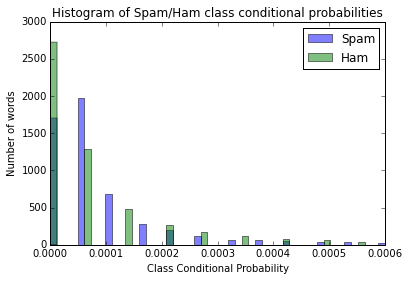

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def run_2_3():
    
    #Load/clean data into pandas for easy plotting
    data=pd.read_csv("histogram_data.txt", sep='\t', header=None)
    columns=['word','p_spam','p_ham']
    data.columns=columns
    #Remove summary stat rows returned by the mapper, which have no value for p_ham
    data=data[np.isfinite(data['p_ham'])] 

    #PLOT HISTOGRAM
    
    #50 bins between 0 and 0.0006
    #Any wider range than that is hard to read
    bins = np.linspace(0, 0.0006, 50) 
    plt.hist(data['p_spam'], bins, alpha=0.5, label='Spam')
    plt.hist(data['p_ham'], bins, alpha=0.5, label='Ham')
    plt.xlabel("Class Conditional Probability")
    plt.ylabel("Number of words")
    plt.title("Histogram of Spam/Ham class conditional probabilities")
    plt.legend(loc='upper right')
    plt.show()

run_2_3()

Here, we can clearly see that most of the class conditional probabilites are VERY low, including many that are actually zero.  This is going to cause two problems.  First, when we multiply lots of small values together, we're likely to encounter floating point underflow.  We can fix this by using log probabilities (which we do above).  The second problem occurs when we have words that don't appear in one class or the other, since, if we took no action, this would mean that the appearance of any word with zero class probability in a message would imply that the entire message had zero class probability, which is clearly incorrect.  We skip these situations in this problem, but a better way to address this is by applying smoothing, which we do below.

##HW2.4 
*Repeat HW2.3 with the following modification: use Laplace plus-one smoothing. Compare the misclassifcation error rates for 2.3 versus 2.4 and explain the differences.*


#### HW 2.4 - Mapper #2
Since the structure of this problem is very similar to 2.3, we can recycle the entire first job and just modify the mapper of the second to make the Laplace smoothing calculation.  For clarity, I have not duplicated code for this problem that is unchanged from 2.3.

In [209]:
%%writefile mapper2.py
#!/usr/bin/python

#HW 2.4 - Mapper #2 Function Code
from __future__ import division
import sys
from math import log,exp
import re
WORD_RE = re.compile(r"[\w']+") #Compile regex to easily parse complete words

words={}
prior_spam=0
prior_ham=0
spam_word_count=0
ham_word_count=0
spam_zero_probs=0
ham_zero_probs=0
fail_count=0
doc_count=0

#Load all conditional probabilites from previous job into memory where {word:{p_spam,p_ham}}
with open('part-00000','rb') as f:
    for line in f.readlines():
        clean_line=line.strip() #strip whitespace, just to be safe
        fields=clean_line.split('\t') #parse remaining line
        if fields[0]=='""PRIORS': #extract special records with priors in it
            prior_spam=float(fields[1])
            prior_ham=float(fields[2])
            continue
        if fields[0]=='""WORD_COUNTS': #extract special records with class counts in it
            spam_word_count=int(fields[1])
            ham_word_count=int(fields[2])
            continue
        #words[fields[0]]={'p_spam':fields[1],'p_ham':fields[2]} #save normal cond probs in memory
        #print fields
        words[fields[0]]={'spam_occurrences':int(fields[1]),'ham_occurrences':int(fields[2])} #save normal cond probs in memory

vocab_count=len(words)
for k,word in words.iteritems():
    #NORMAL VERSION
    #print word
    #word['p_spam']=(word['spam_occurrences'])/(spam_word_count)
    #word['p_ham']=(word['ham_occurrences'])/(ham_word_count)
    
    #SMOOTHING VERSION
    word['p_spam']=(word['spam_occurrences']+1)/(spam_word_count+vocab_count)
    word['p_ham']=(word['ham_occurrences']+1)/(ham_word_count+vocab_count)
    
#Load all raw data from emails
for line in sys.stdin:
    clean_line=line.strip() #strip whitespace, just to be safe
    fields=clean_line.split('\t') #parse remaining line
    true_class=int(fields[1])
    subject_and_body=" ".join(fields[-2:])#parse the subject and body fields from the line, and combine into one string
    words_in_doc=re.findall(WORD_RE,subject_and_body) #create list of unique words in doc

    doc_p_spam=log(prior_spam)
    doc_p_ham=log(prior_ham)
    doc_count+=1
    for word in words_in_doc:
        if words[word]['p_spam']==0:
            
            #If a word doesn't appear in a class, we want to assume the document
            #has a zero probability of being in that class
            #We can achieve this by setting the document class log probabilty
            #to a VERY low number
            doc_p_spam+=-50000 
            spam_zero_probs+=1
        else:
            doc_p_spam+=log(float(words[word]['p_spam']))

        if words[word]['p_ham']==0:
            doc_p_ham+=-50000
            ham_zero_probs+=1
        else:
            doc_p_ham+=log(float(words[word]['p_ham']))

    if doc_p_spam>doc_p_ham:
        pred_class=1
    else:
        pred_class=0
    #print fields[0]+'\t'+str(true_class)+'\t'+str(pred_class)+'\t'+str(doc_p_spam)+'\t'+str(doc_p_ham)
    
    if pred_class!=true_class:
        fail_count+=1

#Special final output - how many times did we deal with a zero prob
print '*misclassification_rate*\t'+str(fail_count/doc_count)
print 'spam_zero_probs\t'+str(spam_zero_probs)
print 'ham_zero_probs\t'+str(ham_zero_probs)

Overwriting mapper2.py


#### HW 2.4 - Testing
Before bothering with Hadoop, we can test everything in the command line to make sure it works right

In [210]:
!cat enronemail_1h.txt | ./mapper.py |sort | ./reducer.py > part-00000
!cat enronemail_1h.txt | ./mapper2.py

*misclassification_rate*	0.0
spam_zero_probs	0
ham_zero_probs	0


####HW 2.4 - Running the Hadoop Jobs
Now that all our files are in place and we've confirmed they work, we can run them in Hadoop.

In [211]:
# Make sure 1st job output directory is clear in HDFS
!bin/hdfs dfs -rm -r hw_2_4_tmp_output

Deleted hw_2_4_tmp_output


In [212]:
%%bash
#Run the first job
bin/hadoop jar share/hadoop/tools/lib/hadoop-streaming-2.6.3.jar \
-file ./mapper.py    -mapper ./mapper.py \
-file ./reducer.py   -reducer ./reducer.py \
-input /user/nicholashamlin/enronemail_1h.txt -output /user/nicholashamlin/hw_2_4_tmp_output;


packageJobJar: [./mapper.py, ./reducer.py, /var/folders/rz/drh189k95919thyy3gs3tq400000gn/T/hadoop-unjar6403601398913752474/] [] /var/folders/rz/drh189k95919thyy3gs3tq400000gn/T/streamjob4165333430757206566.jar tmpDir=null


In [213]:
#Copy output of training job to local filesystem and make sure 
#our job 2 output directory is cleared
!rm ./part-00000
!bin/hdfs dfs -get hw_2_4_tmp_output/part-00000
!bin/hdfs dfs -rm -r hw_2_4_final_output

Deleted hw_2_4_final_output


In [214]:
%%bash
#Run the second job
#The extra -file parameter ensures this job can access the output of the last job
bin/hadoop jar share/hadoop/tools/lib/hadoop-streaming-2.6.3.jar \
-D mapred.map.tasks=1 \
-file ./mapper2.py    -mapper ./mapper2.py \
-file ./reducer2.py   -reducer ./reducer2.py \
-file ./part-00000 \
-input /user/nicholashamlin/enronemail_1h.txt \
-output /user/nicholashamlin/hw_2_4_final_output;


packageJobJar: [./mapper2.py, ./reducer2.py, ./part-00000, /var/folders/rz/drh189k95919thyy3gs3tq400000gn/T/hadoop-unjar6811357885372903663/] [] /var/folders/rz/drh189k95919thyy3gs3tq400000gn/T/streamjob6397016649245665025.jar tmpDir=null


In [215]:
#View results
!bin/hdfs dfs -cat hw_2_4_final_output/*

*misclassification_rate*	0.0
ham_zero_probs	0
spam_zero_probs	0


Here smoothing doesn't make a difference in our misclassification rate because this time instead of manually setting the class probability for a whole document to basically zero, we're letting the smoothing increment the log probability by a very small number, which has a similar effect. This is also why we see the number of instances where we encounter a zero class probability drop from several thousand in 2.3 to none in 2.4.  In practice though, smoothing would make a big difference if we were to test our model on data other than the data that we used to train it, because it enables us to effectively handle words we haven't seen before.

##HW2.5. 
*Repeat HW2.4. This time when modeling and classification ignore tokens with a frequency of less than three (3) in the training set. How does it affect the misclassifcation error of learnt naive multinomial Bayesian Classifier on the training dataset:*

#### HW 2.5 - Mapper #2
As before, we can recycle everything from the previous problems except the second mapper, which is modified to exclude very infrequent words. Again, I have not duplicated code for this problem that is unchanged from earlier.

In [216]:
%%writefile mapper2.py
#!/usr/bin/python

#HW 2.5 - Mapper #2 Function Code
from __future__ import division
import sys
from math import log,exp
import re
WORD_RE = re.compile(r"[\w']+") #Compile regex to easily parse complete words

words={}
prior_spam=0
prior_ham=0
spam_word_count=0
ham_word_count=0
spam_zero_probs=0
ham_zero_probs=0
fail_count=0
doc_count=0

#Load all conditional probabilites from previous job into memory where {word:{p_spam,p_ham}}
with open('part-00000','rb') as f:
    for line in f.readlines():
        clean_line=line.strip() #strip whitespace, just to be safe
        fields=clean_line.split('\t') #parse remaining line
        if fields[0]=='""PRIORS': #extract special records with priors in it
            prior_spam=float(fields[1])
            prior_ham=float(fields[2])
            continue
        if fields[0]=='""WORD_COUNTS': #extract special records with class counts in it
            spam_word_count=int(fields[1])
            ham_word_count=int(fields[2])
            continue

        #This is the change that excludes infrequent words
        #Only consider words part of the vocabulary if they have a combined spam/ham 
        #occurrence of 3 or more
        if int(fields[1])+int(fields[2])>=3:
            words[fields[0]]={'spam_occurrences':int(fields[1]),'ham_occurrences':int(fields[2])} #save normal cond probs in memory

vocab_count=len(words)

for k,word in words.iteritems():
    #NORMAL VERSION
    #print word
    #word['p_spam']=(word['spam_occurrences'])/(spam_word_count)
    #word['p_ham']=(word['ham_occurrences'])/(ham_word_count)
    
    #SMOOTHING VERSION
    word['p_spam']=(word['spam_occurrences']+1)/(spam_word_count+vocab_count)
    word['p_ham']=(word['ham_occurrences']+1)/(ham_word_count+vocab_count)
    
#Load all raw data from emails
for line in sys.stdin:
    clean_line=line.strip() #strip whitespace, just to be safe
    fields=clean_line.split('\t') #parse remaining line
    true_class=int(fields[1])
    subject_and_body=" ".join(fields[-2:])#parse the subject and body fields from the line, and combine into one string
    words_in_doc=re.findall(WORD_RE,subject_and_body) #create list of unique words in doc

    doc_p_spam=log(prior_spam)
    doc_p_ham=log(prior_ham)
    doc_count+=1
    for word in words_in_doc:
        
        #This construction is a little different than in the previous mappers
        #to make dealing with infrequent words cleaner, but the logic is 
        #exactly the same.
        try:
            doc_p_spam+=log(float(words[word]['p_spam']))
        except ValueError:
            spam_zero_probs+=1
            doc_p_spam=-50000
        except KeyError: #ignore infrequent words
            pass

        try:
            doc_p_ham+=log(float(words[word]['p_ham']))
        except ValueError:
            ham_zero_probs+=1
            doc_p_spam=-50000
        except KeyError: #ignore infrequent words
            pass

    if doc_p_spam>doc_p_ham:
        pred_class=1
    else:
        pred_class=0
    #print fields[0]+'\t'+str(true_class)+'\t'+str(pred_class)+'\t'+str(doc_p_spam)+'\t'+str(doc_p_ham)
    
    if pred_class!=true_class:
        fail_count+=1

#Special final output - how many times did we deal with a zero prob
print '*misclassification_rate*\t'+str(fail_count/doc_count)
print 'spam_zero_probs\t'+str(spam_zero_probs)
print 'ham_zero_probs\t'+str(ham_zero_probs)

Overwriting mapper2.py


#### HW 2.5 - Testing
Before bothering with Hadoop, we can test everything in the command line to make sure it works right

In [217]:
!cat enronemail_1h.txt | ./mapper.py |sort | ./reducer.py > part-00000
!cat enronemail_1h.txt | ./mapper2.py

*misclassification_rate*	0.02
spam_zero_probs	0
ham_zero_probs	0


####HW 2.5 - Running the Hadoop Jobs
Now that all our files are in place and we've confirmed they work, we can run them in Hadoop.

In [218]:
# Make sure 1st job output directory is clear in HDFS
!bin/hdfs dfs -rm -r hw_2_5_tmp_output

Deleted hw_2_5_tmp_output


In [219]:
%%bash
#Run the first job
bin/hadoop jar share/hadoop/tools/lib/hadoop-streaming-2.6.3.jar \
-file ./mapper.py    -mapper ./mapper.py \
-file ./reducer.py   -reducer ./reducer.py \
-input /user/nicholashamlin/enronemail_1h.txt -output /user/nicholashamlin/hw_2_5_tmp_output;


packageJobJar: [./mapper.py, ./reducer.py, /var/folders/rz/drh189k95919thyy3gs3tq400000gn/T/hadoop-unjar4647339919209417233/] [] /var/folders/rz/drh189k95919thyy3gs3tq400000gn/T/streamjob2053424481046385722.jar tmpDir=null


In [220]:
#Copy output of training job to local filesystem and make sure 
#our job 2 output directory is cleared
!rm ./part-00000
!bin/hdfs dfs -get hw_2_5_tmp_output/part-00000
!bin/hdfs dfs -rm -r hw_2_5_final_output

Deleted hw_2_5_final_output


In [221]:
%%bash
#Run the second job
#The extra -file parameter ensures this job can access the output of the last job
bin/hadoop jar share/hadoop/tools/lib/hadoop-streaming-2.6.3.jar \
-D mapred.map.tasks=1 \
-file ./mapper2.py    -mapper ./mapper2.py \
-file ./reducer2.py   -reducer ./reducer2.py \
-file ./part-00000 \
-input /user/nicholashamlin/enronemail_1h.txt \
-output /user/nicholashamlin/hw_2_5_final_output;


packageJobJar: [./mapper2.py, ./reducer2.py, ./part-00000, /var/folders/rz/drh189k95919thyy3gs3tq400000gn/T/hadoop-unjar5983750829402776251/] [] /var/folders/rz/drh189k95919thyy3gs3tq400000gn/T/streamjob949079005686631761.jar tmpDir=null


In [222]:
#View results
!bin/hdfs dfs -cat hw_2_5_final_output/*

*misclassification_rate*	0.02
ham_zero_probs	0
spam_zero_probs	0


Again, we have no instances where we encounter a zero class conditional probability (since we're still using Laplace smoothing).  However, our misclassification rate increases incrementally when we exclude infrequent words.  Rare words are likely to be distinctive, so it would make sense that they'd appear in one class or the other, but probably not both.  In this case, the tradeoff to the slightly higher misclassification rate is that not only is our stored vocabulary much smaller, but the model is also likely to generalize better to prevously unseen data.  

##HW2.6 

*Benchmark your code with the Python SciKit-Learn implementation of the multinomial Naive Bayes algorithm. In this exercise, please complete the following:*

- *Run the Multinomial Naive Bayes algorithm (using default settings) from SciKit-Learn over the same training data used in HW2.5 and report the misclassification error (please note some data preparation might be needed to get the Multinomial Naive Bayes algorithm from SkiKit-Learn to run over this dataset)*
- *Prepare a table to present your results, where rows correspond to approach used (SkiKit-Learn versus your Hadoop implementation) and the column presents the training misclassification error*
- *Explain/justify any differences in terms of training error rates over the dataset in HW2.5 between your Multinomial Naive Bayes implementation (in Map Reduce) versus the Multinomial Naive Bayes implementation in SciKit-Learn*

#### HW 2.6 - Training error function
It's convenient to define a simple function that we can use to calculate the training error for our predictions.  

In [12]:
#HW 2.6 Training Error Function

from __future__ import division

def calculate_training_error(pred, true):
    """Calculates the training error given a vector 
    of predictions and a vector of true classes"""
    
    num_wrong=0
    for i in zip(pred,true):
        if i[0]!=i[1]: #If predicted value doesn't equal true value, increment our count
            num_wrong+=1
            
    #Divide number of incorrect examples by total number of examples in the data
    print "Training error: "+str(num_wrong/len(pred))

#### HW 2.6 - Scikit-Learn implementation

In [14]:
#HW 2.6 - Model comparison code

#Load required packages
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

def run_2_6():

    #Load data and preprocess for easy scikit-learn use
    with open('enronemail_1h.txt','rb') as f:
        data=pd.read_csv(f, sep='\t', header=None)
    columns=['id','spam','subject','body']
    data.columns=columns #change column headers for easier reference
    data = data.fillna('') #remove nulls
    data['text']=data['subject']+data['body'] #combine subject and body into one field
    
    #Break data into vocabulary
    vec=CountVectorizer(analyzer='word')
    vocab=vec.fit_transform(data['text'])

    #Run Sklearn implementation of Multinomial NB
    mnb = MultinomialNB()
    mnb.fit(vocab,data['spam'])
    m_results=mnb.predict(vocab)
    print "Multinomial NB Results via Scikit-Learn Implementation"
    calculate_training_error(m_results,data['spam'])
    
run_2_6()

Multinomial NB Results via Scikit-Learn Implementation
Training error: 0.0


#### HW 2.6 - Summary of Results

| Model                                                                      | Training Error |
|----------------------------------------------------------------------------|----------------|
| Multinomial NB, Scikit-Learn Implementation                                | 0.0            |
| Multinomial NB, Hadoop Implementation                                  | 0.02           |  

The scikit-learn version of Multinomial NB does slightly better than our final MapReduce implementation.  This makes sense because by default, scikit-learn implements Laplace smoothing (alpha=1.0) the same way we did in HW 2.4 and 2.5.  However, it does not make any default assumptions about excluding infrequent words (though it can be easily modified to do that).  Given this, it makes sense that Scikit-learn would do slightly better than our results from 2.5. In addition, it's not surprising that we should see no training error, because we are evaluating our model on the same dataset on which we trained it.

##HW 2.6.1 OPTIONAL (note this exercise is a stretch HW and optional)
- *Run the Bernoulli Naive Bayes algorithm from SciKit-Learn (using default settings) over the same training data used in HW2.6 and report the misclassification error*  
- *Discuss the performance differences in terms of misclassification error rates over the dataset in HW2.5 between the  Multinomial Naive Bayes implementation in SciKit-Learn with the  Bernoulli Naive Bayes implementation in SciKit-Learn. Why such big differences. Explain.*

*Which approach to Naive Bayes would you recommend for SPAM detection? Justify your selection.*

In [39]:
def run_2_6_1():
    #Load data and preprocess for easy scikit-learn use
    with open('enronemail_1h.txt','rb') as f:
        data=pd.read_csv(f, sep='\t', header=None)
    columns=['id','spam','subject','body']
    data.columns=columns #change column headers for easier reference
    data = data.fillna('') #remove nulls
    data['text']=data['subject']+data['body'] #combine subject and body into one field
    
    #Break data into vocabulary
    vec=CountVectorizer(analyzer='word')
    vocab=vec.fit_transform(data['text'])
    
    #Run Sklearn implementation of Bernoulli NB
    bnb = BernoulliNB()
    bnb.fit(vocab,data['spam'])
    b_results=bnb.predict(vocab)
    print "Bernoulli NB Results via Scikit-Learn Implementation"
    calculate_training_error(b_results,data['spam'])
    
run_2_6_1()

Bernoulli NB Results via Scikit-Learn Implementation
Training error: 0.16


#### HW 2.6.1 - Summary of Results

| Model                                                                      | Training Error |
|----------------------------------------------------------------------------|----------------|
| Multinomial NB, Scikit-Learn Implementation                                | 0.0            |
| Bernoulli NB, Scikit-Learn Implementation                                   | 0.16           |  

When running the different flavors of Naive Bayes in scikit-learn, we see that the Bernoulli implementation has a slightly higher error rate than the Multinomial version, which correctly classifies all the emails.  The difference here derives from the assumptions required for each model.  In the Bernoulli NB implementation, features are assumed to come from a bernoulli distribution, that is, each feature is assumed to be binary.  In contrast, a multinomial NB model assumes features come from a discrete distribution (each feature is a categorical variable, rather than binary).  Since our source data is in terms of word counts, we should expect the Multinomial NB to perform better than the Bernoulli version. 

I'd imagine the multinomial approach is probably better for spam classification based on the following two example emails:

1. "Hi Doc, I think my viagra perscription is interacting with my heart meds.  Please advise."
2. "Viagra Viagra Viagra Viagra Viagra Viagra Viagra Viagra Viagra"

Intuitively, the second email is more likely to be spam than the first.  A multinomial approach would distinguish between the two, but a bernoulli approach wouldn't.

###End of Submission